<a href="https://colab.research.google.com/github/FKz11/NN_PyTorch/blob/main/lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-5

### Библиотеки:

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## 1. Подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

### Данные

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/lips.zip'

In [116]:
DATA_ROOT = '/content/set-lipstick-original/'

In [117]:
df = pd.read_csv(DATA_ROOT + 'list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [118]:
df.shape

(28594, 9)

In [119]:
df.isna().sum().sum()

0

In [121]:
for root, dirs, files in os.walk(DATA_ROOT + '720p/'):
  df = df[df['filename'].apply(lambda x: x in files)]

In [122]:
for root, dirs, files in os.walk(DATA_ROOT + 'mask/'):
  df = df[df['mask'].apply(lambda x: x in files)]

In [123]:
df.shape

(28540, 9)

In [124]:
df = df[['filename', 'mask']]
df['filename'] = DATA_ROOT + '720p/' + df['filename']
df['mask'] = DATA_ROOT + 'mask/' + df['mask']
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,filename,mask
0,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
1,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
2,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
3,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
4,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...


### Пример данных

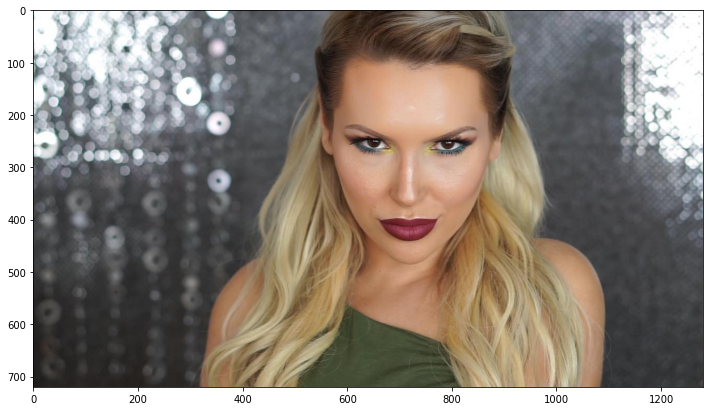

In [125]:
img = plt.imread(df['filename'][0])
plt.figure(figsize = (12,12))
plt.imshow(img);

In [126]:
img.shape

(720, 1280, 3)

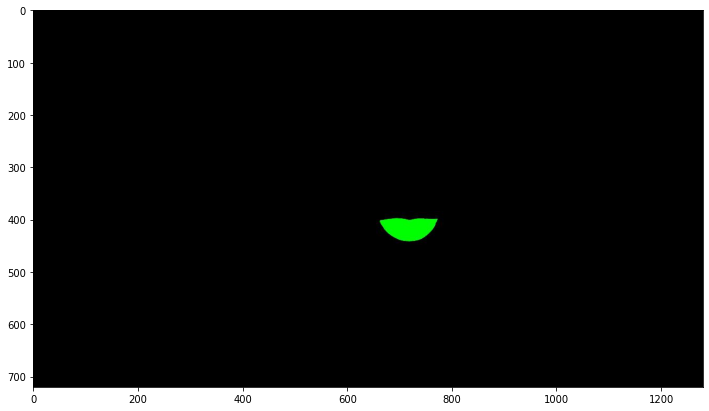

In [127]:
mask = plt.imread(df['mask'][0])
plt.figure(figsize = (12,12))
plt.imshow(mask);

In [128]:
mask.shape

(720, 1280, 3)

### Dataset

In [155]:
class MyDataset(Dataset):
    def __init__(self, df, size=None, min_prob=None):
      
      self.df = df
      self.size = size
      self.min_prob = min_prob

    def __getitem__(self, index):

      img = plt.imread(self.df['filename'][index])
      img = transforms.ToTensor()(img)

      mask = plt.imread(self.df['mask'][index])
      if len(mask.shape) == 3:
        mask = mask[..., 1]
      mask = transforms.ToTensor()(mask)

      if self.size is not None:
        img = transforms.Resize(self.size, interpolation=transforms.InterpolationMode.NEAREST)(img)
        mask = transforms.Resize(self.size, interpolation=transforms.InterpolationMode.NEAREST)(mask)

      if self.min_prob is not None:
        mask = (mask > self.min_prob).float()

      return img, mask

    def __len__(self):
      return self.df.shape[0]

### Наглядный пример влияния методов интерполяции при изменении размера изображения

In [130]:
img = np.array([[[1, 1, 1], [0,0,0], [0.5,0.5,0.5]], [[1, 1, 1], [0,0,0], [0.5,0.5,0.5]]])

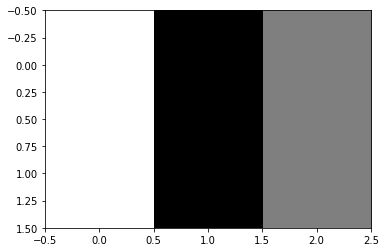

In [131]:
plt.imshow(img)
plt.show()

In [132]:
transform = transforms.Compose([transforms.ToTensor(),
          transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)])

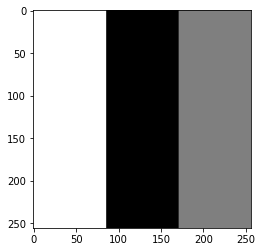

In [133]:
plt.imshow(transform(img).permute(1, 2, 0))
plt.show()

In [134]:
transform = transforms.Compose([transforms.ToTensor(),
          transforms.Resize((256, 256))])

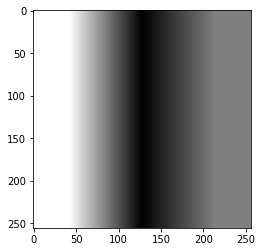

In [135]:
plt.imshow(transform(img).permute(1, 2, 0))
plt.show()

### train_test_split

In [136]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [187]:
train_data = MyDataset(train_df, size=(256, 256), min_prob=None)
test_data = MyDataset(test_df, size=(256, 256), min_prob=None)

### DataLoader

In [188]:
train_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True,
    num_workers=2,

)
test_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=1,
)

## 2. Обучить модель на выбор из segmentation_models_pytorch

In [139]:
!pip install -qq segmentation-models-pytorch

In [140]:
import segmentation_models_pytorch as smp

In [141]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Создание модели

In [189]:
BACKBONE = 'resnet34'
segmodel = smp.FPN(BACKBONE, classes=1, encoder_weights='imagenet', activation='sigmoid').to(device)

In [190]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [191]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

### Обучение

In [192]:
epochs = 3

for i in range(0, epochs):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)

Epoch: 1
valid: 100%|██████████| 2141/2141 [07:14<00:00,  4.93it/s, dice_loss - 0.118, iou_score - 0.8211]
Epoch: 2
valid: 100%|██████████| 2141/2141 [06:59<00:00,  5.11it/s, dice_loss - 0.1055, iou_score - 0.8156]
Epoch: 3
valid: 100%|██████████| 2141/2141 [07:15<00:00,  4.92it/s, dice_loss - 0.07352, iou_score - 0.8651]


### Пример предсказаний

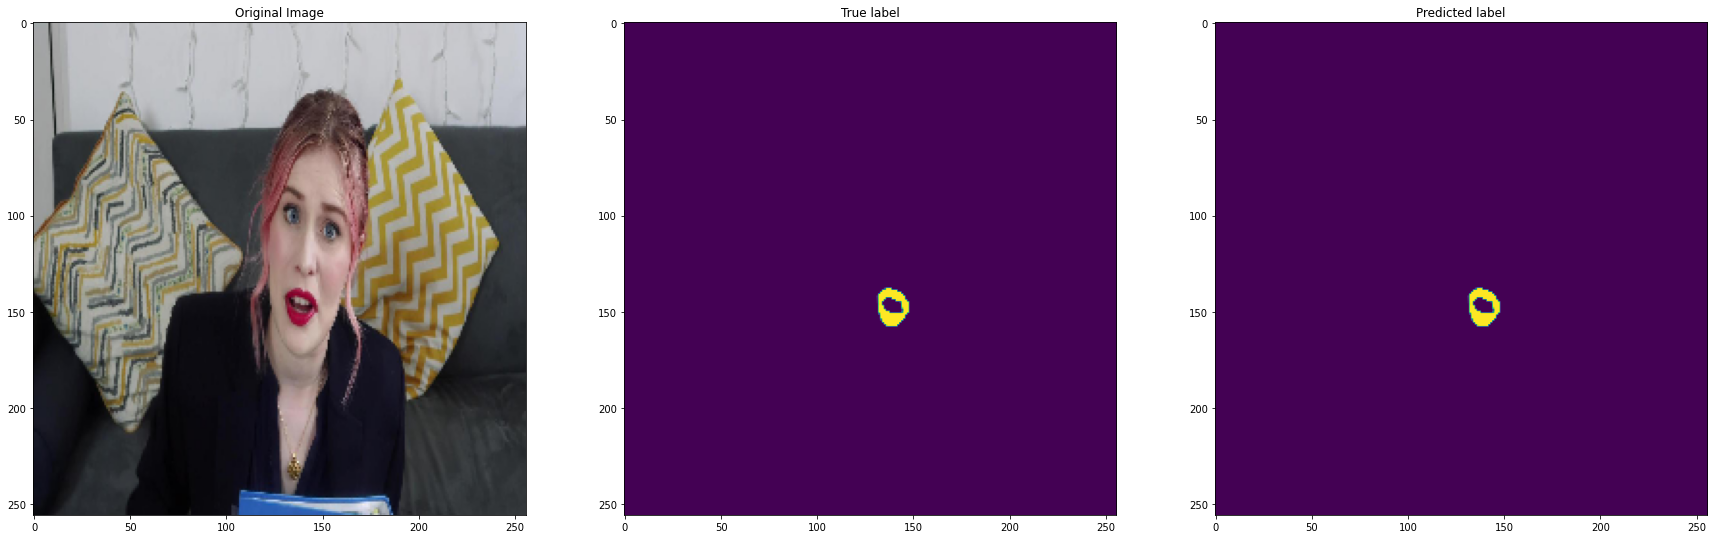

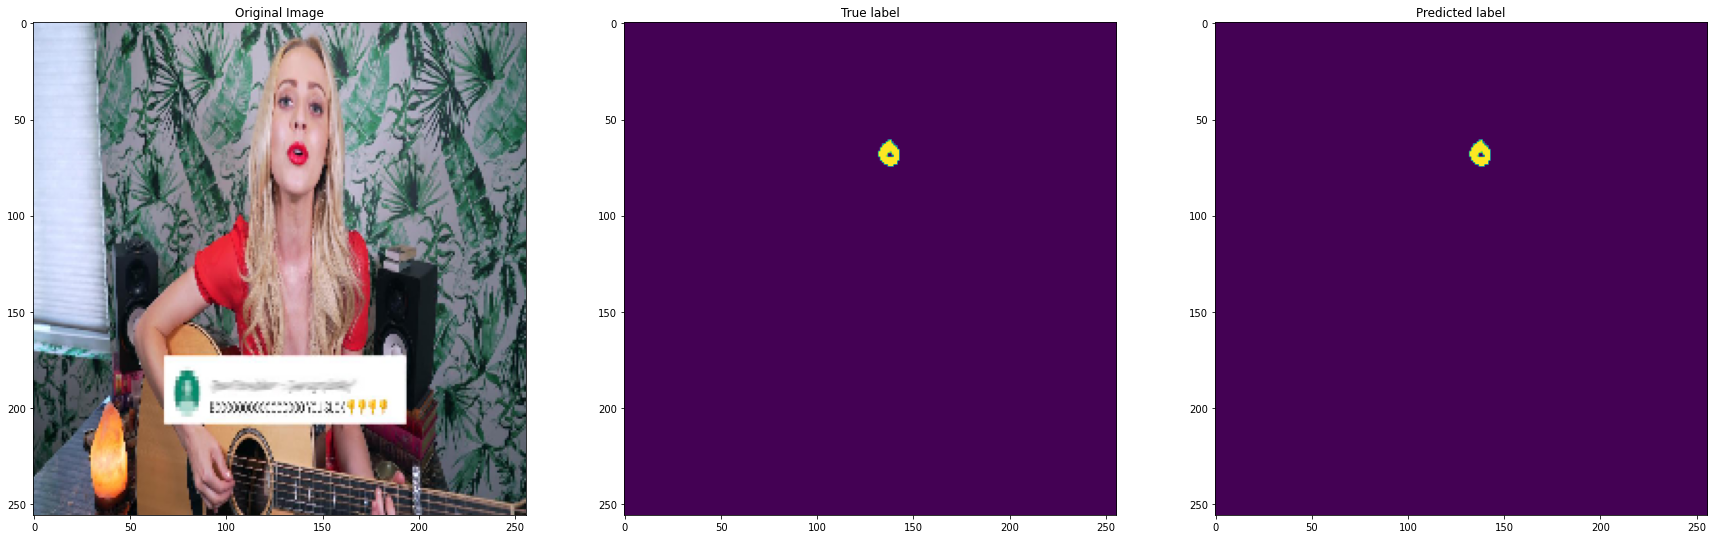

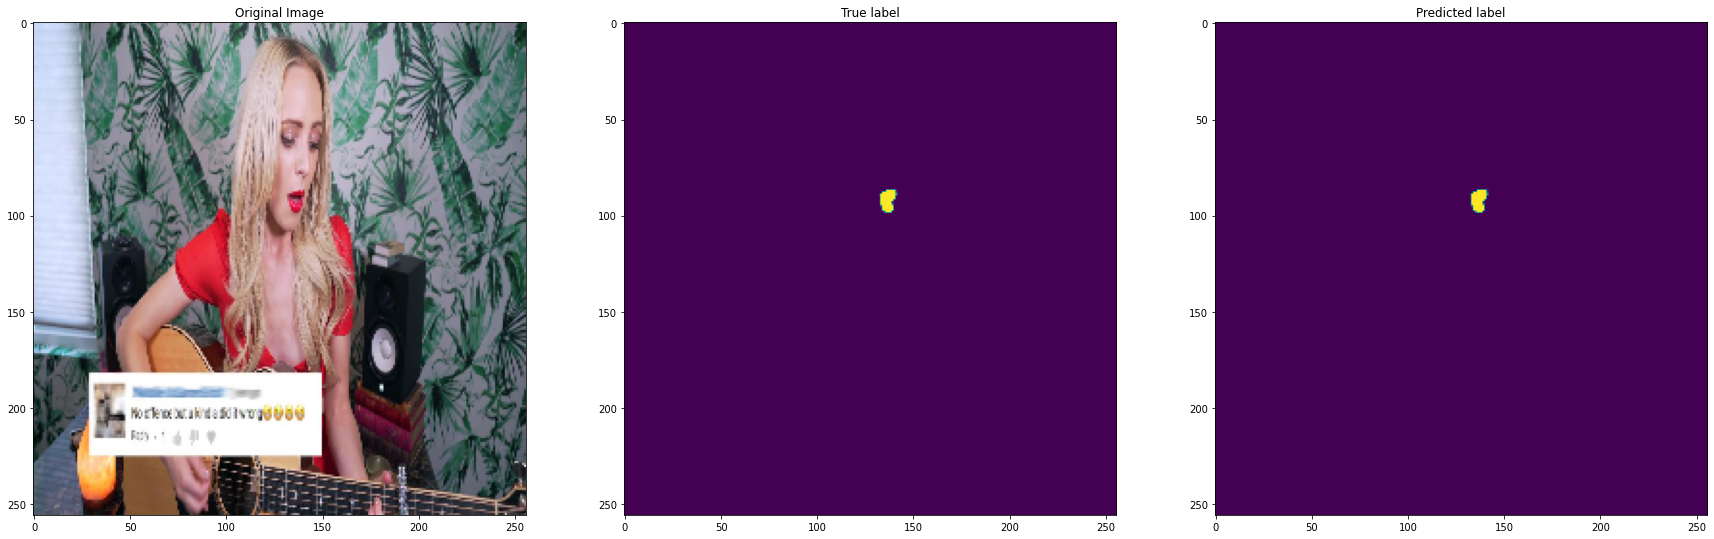

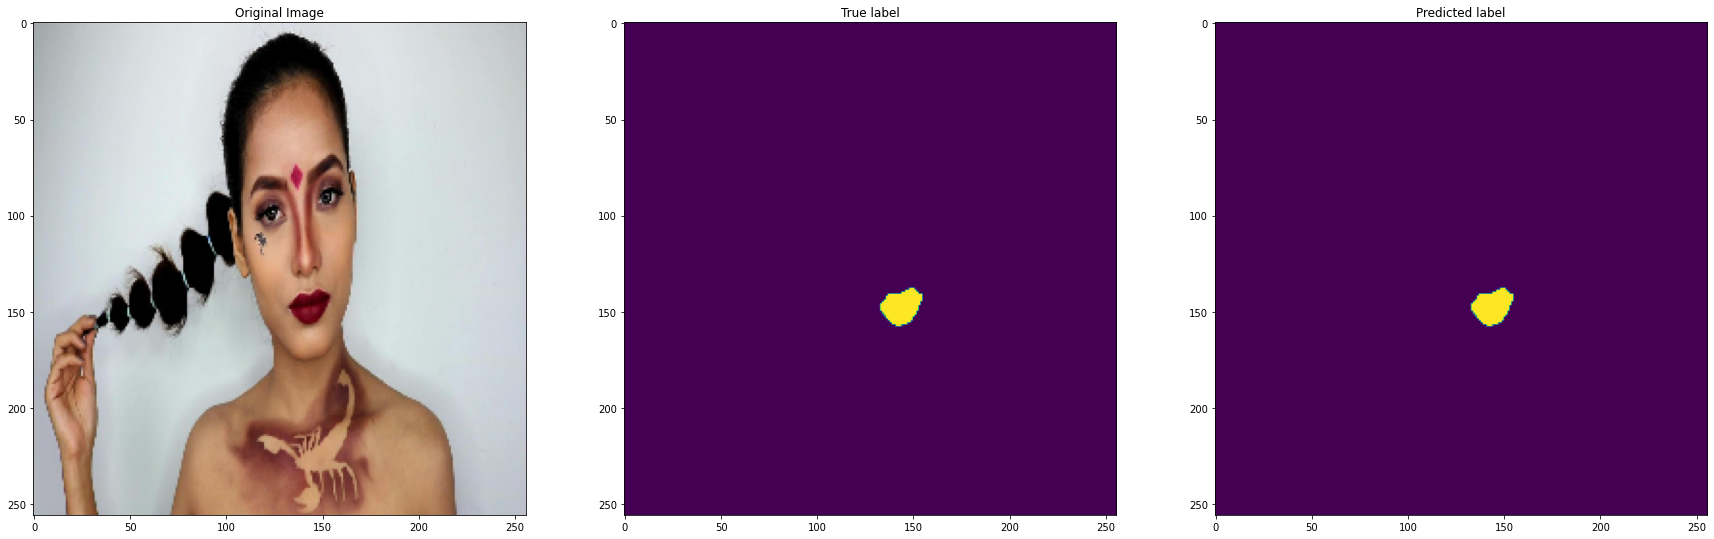

In [230]:
for data in test_loader:
  images, labels = data
  outputs = segmodel(images.to(device))
  outputs = outputs.squeeze().detach().cpu()
  images = images.permute([0,2,3,1])
  labels = labels.squeeze()

  for i in range(test_loader.batch_size):
    fig, ax = plt.subplots(1,3, figsize=(30, 10))
    ax[0].imshow(images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(outputs[i])
    ax[1].set_title('True label')
    ax[2].imshow(outputs[i])
    ax[2].set_title('Predicted label')
    plt.show()

  break

### Сохранение

In [232]:
save_model_path = DATA_ROOT + 'segmodel.pth'

In [233]:
torch.save(segmodel.state_dict(), save_model_path)

## Вывод:

Я узнал, что если разархивировать файлы заранее на диске и пытаться их загружать в colab по одному, то обучение растягивается до 10 часов, но если загрузить архив и уже в colab применить функцию !unzip, то все файлы сразу видны colab, путь до них стоновится короче и обучение уже занимает 12 минут, как и должно быть.

Я сравнил csv файл и данные из архива и обнаружил, что для 28594 - 28540 = 54 примеров нету масок, и удалил эти примеры.

Я решил не использовать новую библиотеку cv2. Поэтому я при изменении размера применял transforms.InterpolationMode.NEAREST интерполяцию, ради которой мы и использовали cv2.

Я показал, как сильно влияет метод интерполяции на измененное изображение, на примере растягивания трёх полос.

Обычно, когда данные строго размечены по классам(0, 1, 2, 3, 4), то нам важно, чтобы при изменении размеров изображения у нас не появилось новых сзначений, например, 3.5 или 3.9, поэтому нужно использовать интерполяцию, которая не создаёт новых значений, а использует существующие (интерполяция ближайшими соседями(transforms.InterpolationMode.NEAREST)), хотя и картинка иногда получается слишком резкой и менее правдоподобной.

Но у нас изначально данные размечены как обычная трёхканальная картинка, где зелёный канал обеспечивает 99% информации, который мы потом только и используем. В зелёнов канале данные выглядят как от 0 до 1, где 1 - губы, 0 - фон, 0..1 - граница.

Мы можем сделать min_prob или threshold, это порог, который отсекает недостаточно уверенные метки, этот параметр напрямую влияет на precision и recall предсказаний в будущем для исходных изображений, если его увеличивать(тоесть остовлять меньше меток, которые будут до границ губ и их легко классифицировать) то precision увеличивается, recall уменьшается, и наоборот. Уменьшаем параметр (остовляем больше меток, которые будут за границей губ, модель будет больше ошибаться, но будет стараться выделять больше меток, в том числе границы), precision уменьшается, recall увеличивается. При этом, этот же порог имеет большой смысл использовать на выходе модели, чтобы получить бинарный выход для бинарной макси. Оптимальный порог будет 0.5. Но его можно менять в зависимости от того, что для задачи важнее, precision или recall.

А можно ничего не делать и тогда для модели будет выглядеть, что данные это не бинарные метки, а их вероятность. Где 1, это полная уверенность, что это метка, а 0, что её здесть точно нету. 0.5 - это вероятность, что она здесь как может быть, так её может и не быть с одинаковой вероятностью. Модели становится проще понимать где границы.

Модель начинает быстрее сходится на старте, так как начальные градиенты перестают быть слишком большие. А так же точнее сходится в конце, так как модели не приходится прыгать с 0 до 1 и обратно, при классификации точек на границе, она предсказывает число в районе 0.5 лишь немного меняя его.

Так же я понял, что функция активации 'softmax2d' имеет смысл, только когда у нас больше одного класса, так как она приводит данные к виду, что в каждой точке сумма всех каналов равна единице, чтобы каждый вывод был от 0 до 1 и при этом сохранялся лидер, тоесть тот канал, где значени было больше остальных. А когда у нас один класс, то при применении этой функции, какая бы не была вероятность в точке, она все равно будет больше всех, так как других просто нету, поэтому в каждой точке будет стоять цифра один, и на выходе будет просто белый фон.

Я обучил модель, посмотрел на предсказания, они получилсиь почти индентичными маске. Так же метрика iou_score = 0.8651 на тесте. Что означает, что модель обучалась успешно.

Я сохранил модель.

